# TODOs
1. ### <s> Lemmatize input - Good
2. ### <s> Replace CNNs with KAN-CNNs - Won't learn, Revisit last
3. ### Prune and test
4. ### <s> B-spline Finetuning - Best with splines = 3
5. ### CNN operates on whole embedded lvl - test on various depths (3, 9, 27, 81)
6. ### Deeper CNN - 1 + 3 + 5 gram feed into Deep CNN -> KAN 
7. ### Data Augmentation
8. ### Limit Vocab Size
9. ### Try Word2Vec or Glove pre-trained

In [1]:
from fastkan import FastKAN as KAN

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from fastkan import FastKAN as KAN

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from transformers import GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv('./imdb.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Convert labels to binary
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 1325708.80it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [5]:
# Check for dataset imbalance
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
# Review token length
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 110251.55it/s]


,review,sentiment,label,token_length
0,One of the other reviewers has mentioned that ...,positive,1,307
1,A wonderful little production. <br /><br />The...,positive,1,162
2,I thought this was a wonderful way to spend ti...,positive,1,166
3,Basically there's a family where a little boy ...,negative,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230


In [7]:
data_pos = data[data['label'] == 1]
print("Positive review length")
data_pos['token_length'].describe()

Positive review length


count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [8]:
data_neg = data[data['label'] == 0]
print("Negative review length")
data_neg['token_length'].describe()

Negative review length


count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

In [9]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 
    words = word_tokenize(text)
    sent = [word for word in words if word not in stop_words]
    sent = ' '.join(sent)
    
    return sent

In [10]:
# Preprocessing
data['clean'] = data.review.progress_apply(preprocess_text)
data.head()

100%|██████████| 50000/50000 [00:25<00:00, 1982.66it/s]


,review,sentiment,label,token_length,clean
0,One of the other reviewers has mentioned that ...,positive,1,307,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,1,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,138,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,petter mattei love time money visually stunnin...


In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [12]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize the text if necessary
    words = text.split()
    # Lemmatize each word in the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [13]:
data['lemma'] = data['clean'].progress_apply(lemmatize_text)

100%|██████████| 50000/50000 [00:14<00:00, 3513.94it/s]


In [14]:
# for n in range(20):
#     print(data['clean'][n])
#     print(data['lemma'][n])

In [15]:
tokenizer.pad_token = tokenizer.eos_token
max_l = 256
data['tokenized'] = data.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))

100%|██████████| 50000/50000 [00:31<00:00, 1577.58it/s]


In [16]:
# # Check actual tokenized text len
# data['ct_length'] = data.tokenized.progress_apply(lambda x: len(x))
# data_pos = data[data['label'] == 1]
# data_pos['ct_length'].describe()

In [17]:
# split the data
X = data.tokenized
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.tolist()).to(device)
y_train_tensor = torch.tensor(y_train.tolist()).to(device)
y_test_tensor = torch.tensor(y_test.tolist()).to(device)

# Create Datasets - tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [18]:
# Batch the data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Model -.-% ACC
# Small + BiLSTM

class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CustomCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Conv layers with different kernel sizes
        self.conv1 = nn.Conv2d(1, 256, (1, embed_dim), padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.25) 
        
        self.conv2 = nn.Conv2d(1, 256, (3, embed_dim), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.25) 
        
        self.conv3 = nn.Conv2d(1, 256, (5, embed_dim), padding=(2, 0))
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.25) 
        
        # Post PCAT Conv 1
        self.final_conv = nn.Conv2d(3 * 256, 1024, (3, 3), padding=(1, 1))
        
        self.bn_final = nn.BatchNorm2d(1024)
        self.pool_final = nn.MaxPool2d((2, 1))
        self.dropout_pcat1 = nn.Dropout(0.25)

        # Post PCAT Conv 2
        self.conv_pcat2 = nn.Conv2d(1024, 2048, (3, 3), padding=(1, 1))

        self.bn_pcat2 = nn.BatchNorm2d(2048)
        self.pool_pcat2 = nn.MaxPool2d((2, 1))
        self.dropout_pcat2 = nn.Dropout(0.25)

        # Post PCAT Conv 3
        self.conv_pcat3 = nn.Conv2d(2048, 4096, (3, 3), padding=(1, 1))

        self.bn_pcat3 = nn.BatchNorm2d(4096)
        self.pool_pcat3 = nn.MaxPool2d((4, 1))
        self.dropout_pcat3 = nn.Dropout(0.25)

        # BiLSTM
        self.bilstm = nn.LSTM(input_size=32768, hidden_size=1024, num_layers=1, bidirectional=True, batch_first=True)
        
        # Replace dense layers with FastKAN
        self.kan = KAN([2048, 256, 64, 2], num_grids=8)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        
        # Embedding
        x = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, seq_len, embed_dim)
        
        # Conv layer 1
        x1 = self.conv1(x)  # shape: (batch_size, 100, seq_len-0, 1)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = x1.squeeze(3)  # shape: (batch_size, 100, seq_len-0)
        x1 = self.pool1(x1)  # shape: (batch_size, 100, (seq_len-0)//2)
        x1 = self.dropout1(x1)
        
        # Conv layer 2
        x2 = self.conv2(x)  # shape: (batch_size, 100, seq_len-2, 1)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = x2.squeeze(3)  # shape: (batch_size, 100, seq_len-2)
        x2 = self.pool2(x2)  # shape: (batch_size, 100, (seq_len-2)//2)
        x2 = self.dropout2(x2)
        
        # Conv layer 3
        x3 = self.conv3(x)  # shape: (batch_size, 100, seq_len-4, 1)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = x3.squeeze(3)  # shape: (batch_size, 100, seq_len-4)
        x3 = self.pool3(x3)  # shape: (batch_size, 100, (seq_len-4)//2)
        x3 = self.dropout3(x3) 
        
        # Concatenate along the channel dimension
        x_cat = torch.cat((x1, x2, x3), dim=1)  # shape: (batch_size, 300, ...)
        x_cat = x_cat.unsqueeze(3)  # shape: (batch_size, 300, ..., 1)
        
        # PCAT1 Conv2D layer
        x_out = self.final_conv(x_cat)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_final(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_final(x_out)  # shape: (batch_size, 100, ..., 1)

        x_out = self.dropout_pcat1(x_out)

        # PCAT2 Conv2D layer
        x_out = self.conv_pcat2(x_out)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_pcat2(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat2(x_out)  # shape: (batch_size, 100, ..., 1)

        # PCAT3 Conv2D layer
        x_out = self.conv_pcat3(x_out)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_pcat3(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat3(x_out)  # shape: (batch_size, 100, ..., 1)
        
        # Flatten the tensor for the dense layer
        x_out = x_out.view(x_out.size(0), -1)  # shape: (batch_size, 100)
        x_out = self.dropout_pcat3(x_out)

        # Pass through BiLSTM
        bilstm_out, _ = self.bilstm(x_out)  # bilstm_out shape: (batch_size, seq_len, hidden_size*2)

        # Use the last hidden state from both directions
        bilstm_out = bilstm_out.squeeze(1)
        
        # Dense layer
        x_out = self.kan(bilstm_out)  # shape: (batch_size, num_classes)
        
        return x_out

# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 32  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = CustomCNN(vocab_size, embed_dim)
model.to(device)

CustomCNN(
  (embedding): Embedding(50257, 32)
  (conv1): Conv2d(1, 256, kernel_size=(1, 32), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(1, 256, kernel_size=(3, 32), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(1, 256, kernel_size=(5, 32), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (final_conv): Conv2d(768, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [20]:
from torchinfo import summary
summary(model, input_size=(batch_size, max_l), dtypes=([torch.int64]), col_names=["kernel_size", "input_size", "output_size", "num_params"])

d:\python22-23\imgrecfastkan\venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                             Kernel Shape              Input Shape               Output Shape              Param #
CustomCNN                                          --                        [64, 256]                 [64, 2]                   --
├─Embedding: 1-1                                   --                        [64, 256]                 [64, 256, 32]             1,608,224
├─Conv2d: 1-2                                      [1, 32]                   [64, 1, 256, 32]          [64, 256, 256, 1]         8,448
├─BatchNorm2d: 1-3                                 --                        [64, 256, 256, 1]         [64, 256, 256, 1]         512
├─MaxPool1d: 1-4                                   2                         [64, 256, 256]            [64, 256, 128]            --
├─Dropout: 1-5                                     --                        [64, 256, 128]            [64, 256, 128]            --
├─Conv2d: 1-6                                      [3, 32]  

In [21]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RAdam(model.parameters(), lr=4e-3, weight_decay=1e-4, decoupled_weight_decay=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer = optim.SparseAdam(model.parameters(), lr=1e-3)

# Learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

# Accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop
num_epochs = 100
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/(len(train_loader)*batch_size)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/100: 100%|██████████| 625/625 [02:20<00:00,  4.46it/s, accuracy=0.503, loss=0.0114]


Epoch 1, Loss: 0.011433841180801391, Accuracy: 0.502775
Val_Loss: 0.010891866713762284, Val_Accuracy: 0.5047


Epoch 2/100: 100%|██████████| 625/625 [02:19<00:00,  4.48it/s, accuracy=0.501, loss=0.011]


Epoch 2, Loss: 0.010957223451137543, Accuracy: 0.50085
Val_Loss: 0.010941378843784332, Val_Accuracy: 0.4973


Epoch 3/100: 100%|██████████| 625/625 [02:19<00:00,  4.47it/s, accuracy=0.5, loss=0.0109]  


Epoch 3, Loss: 0.010928444619476795, Accuracy: 0.500225
Val_Loss: 0.011576780194044112, Val_Accuracy: 0.4973


Epoch 4/100: 100%|██████████| 625/625 [02:19<00:00,  4.47it/s, accuracy=0.501, loss=0.0109]


Epoch 4, Loss: 0.010903381125628948, Accuracy: 0.501125
Val_Loss: 0.011010047656297683, Val_Accuracy: 0.5027


Epoch 5/100: 100%|██████████| 625/625 [02:20<00:00,  4.46it/s, accuracy=0.5, loss=0.0109]  


Epoch 5, Loss: 0.010880870258808135, Accuracy: 0.50045
Val_Loss: 0.010880904734134673, Val_Accuracy: 0.5027


Epoch 6/100:  45%|████▍     | 281/625 [01:03<01:17,  4.43it/s, accuracy=0.508, loss=0.0109]


KeyboardInterrupt: 

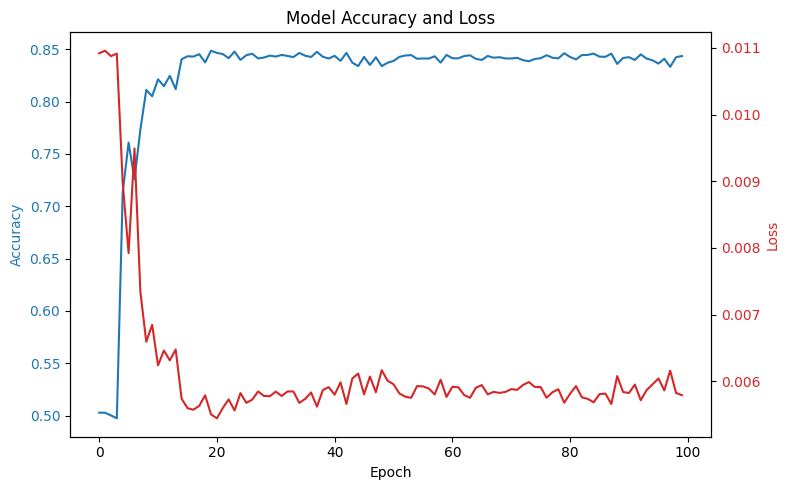

In [36]:
import matplotlib.pyplot as plt

#Plot val acc and loss
accuracy = [entry[0] for entry in model_history]
loss = [entry[1] for entry in model_history]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on primary y
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the loss on secondary y
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Model Accuracy and Loss')
fig.tight_layout()
plt.show()

In [52]:
torch.save(model, './model_saves/model_complete.pth')

In [43]:
del model

In [44]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

In [45]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [27]:
from numba import cuda
 
cuda.select_device(0) # choosing second GPU 
cuda.close()

In [36]:
device = cuda.get_current_device()
device.reset()
cuda.close()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 3080 Laptop GPU''>
